# <center>K Nearest Neighbor and VDM<center>
**<div align=right>Made by:</div>**
<div align=right>Ihor Markevych</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
columns1 = ['pre_rx_cost', 'numofgen', 'numofbrand', 'generic_cost', 'adjust_total_30d' , 'num_er']
columns2 = columns1 + ['regionN']
goal = 'pdc_80_flag'

In [3]:
train = pd.read_csv('healthcareTrain.csv')
train1X = train[columns1]
train2X = train[columns2]
train2X.loc[:, 'regionN'] = train2X['regionN'].astype(str)
trainY = train[goal]

test = pd.read_csv('healthcareTest.csv')
test1X = test[columns1]
test2X = test[columns2]
test2X.loc[:, 'regionN'] = test2X['regionN'].astype(str)
testY = test[goal]

C:\Users\Dergel\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


------------

Linearly scales by the formula
$$\frac{x-x_{min}}{x_{max} - x_{min}}$$

In [4]:
class linearNormalizator:
    
    def fit(self, data):
        self.xMin = data.min()
        self.xMax = data.max()
        
    def scale(self, data):
        return (data - self.xMin) / (self.xMax - self.xMin)
    
    def fitAndScale(self, data):
        self.fit(data)
        return self.scale(data)

--------------

Calculates conditional probability of value `val` and class `c` for Series of values `x` (should contain `val`) and for Series of classes `y` (should contain `c`).

In [5]:
def condProb(val, c, x, y):
    return sum((y[(x == val).tolist()] == c).tolist()) / len(y[(x == val).tolist()])

For runtime optimization, next class was implemented.
  
`fitProbs` creates attribute of conditional attributes;   
`distance` defines VDM distance;
`fitDistances` calculates matrix of distances and stores them as attribute;  
`fit` is equal to `fitProbs` and `fitDistances`.

In [6]:
class VDM:
    
    def fitProbs(self, X, y):
        condProbs = pd.DataFrame()
        
        vals = X.unique()
        vals.sort()
        classes = y.unique()
        classes.sort()

        for val in vals:
            row = []
            for c in classes:
                row += [condProb(val, c, X, y)]
            condProbs = condProbs.append([row])
        condProbs.index = map(str, vals)
        condProbs.columns = map(str, classes)
        
        self.condProbs = condProbs

    def distance(self, val1, val2):
        
        if hasattr(self, 'distances'):
            return self.distances.loc[str(val1), str(val2)]
        else:
            temp = 0
            val1 = str(val1)
            val2 = str(val2)
            for c in self.condProbs.columns:
                c = str(c)
                temp += (self.condProbs.loc[val1, c] - self.condProbs.loc[val2, c]) ** 2
            return temp

    def fitDistances(self):
        distances = pd.DataFrame()

        vals = self.condProbs.index.values

        for val1 in vals:
            row = []
            for val2 in vals:
                row += [self.distance(val1, val2)]
            distances = distances.append([row])
        distances.index = vals
        distances.columns = vals
        self.distances = distances
        
    def fit(self, X, y):
        self.fitProbs(X, y)
        self.fitDistances()

----------

**Weights:**

$\frac{1}{distance^2}$ weights.

In [7]:
def weights(distances):
    with np.errstate(divide='ignore'):
        return np.float64(1) / distances ** 2

Uniform weights (non-weighted kNN).

In [8]:
def uniform(distances):
    return np.array([1 for x in distances])

Next class has next methods:  
  
`distance` calculates mix of Euclidian and VDM distances;  
`fit` fits train $X$ and $y$ data;  
`predictOnePoint` predicts label of one test point (for internal usage);  
`predict` predicts labels for dataframe of test points or for Series of one test sample. 

In [9]:
class kNN:
    def distance(self, val2):
    
        val1 = self.trainX
        val1Num = val1.select_dtypes(include='number')
        val2Num = val2.where([not isinstance(x, str) for x in val2])

        dist = np.sum((val1Num - val2Num) ** 2, axis=1)

        val1Cat = val1.select_dtypes(include='object')
        val2Cat = val2.where([isinstance(x, str) for x in val2])
        val2Cat = val2Cat[val2Cat.notna()]
        
        for clmn in val1Cat.columns:
            vdm = VDM()
            vdm.fit(self.trainX.loc[:, clmn], self.trainY)
            vdmDistances = []
            for _, x in val1Cat.loc[:, clmn].iteritems():
                vdmDistances += [vdm.distance(x, val2Cat[clmn])]
            dist += np.array(vdmDistances)

        return dist ** 0.5
    
    def __init__(self, k, weights=weights):
        self.k = k
#         self.distance = distance
        self.weights = weights
        
    def fit(self, trainX, trainY):
        self.trainX = trainX
        self.trainY = trainY
    
    def predictOnePoint(self, testXPoint):
    #     get vector of distances
        distances = self.distance(testXPoint)
        
    #     get vector of indices of closest neighbors
        neighborsIndexes = np.argpartition(distances, self.k)[:self.k]
        
    #    convert distances into weights
        w = self.weights(distances)
   
    #     get pairs of label - quantity of points with this label
        neighbors = self.trainY[neighborsIndexes].value_counts()

    #     get weights for weighted average
        w = [sum(w[trainY[neighborsIndexes].index[trainY[neighborsIndexes] == label]]) 
                   for label in neighbors.index.values]
        
    #     when there are equal probabilities for several labels function will return first from them 
        return neighbors.index.values[w == np.max(w)][0]

    def predict(self, testX):
        if isinstance(testX, pd.Series):
            testX = testX.to_frame().T
        return testX.apply(self.predictOnePoint, axis=1).values

-------------
-------------
-------------

## Problem 1

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [11]:
lN = linearNormalizator()
train1X = lN.fitAndScale(train1X)
test1X = lN.scale(test1X)

### Weighted:

Using formula $weight = \frac{1}{d^2}$.

#### Custom

In [12]:
accuracies10 = pd.DataFrame(columns = ['k', 'Accuracy'])

for k in range(75, 107, 2):
    knn = kNN(k)
    knn.fit(train1X, trainY)
    accuracies10 = accuracies10.append(pd.DataFrame([[k, accuracy_score(testY, knn.predict(test1X)) * 100]], 
                                                  columns = ['k', 'Accuracy']))    

In [13]:
accuracies10

,k,Accuracy
0,75,62.209302
0,77,62.209302
0,79,62.209302
0,81,61.918605
0,83,62.209302
0,85,62.209302
0,87,62.500000
0,89,61.918605
0,91,61.918605
0,93,61.627907


------------

#### sklearn

In [14]:
accuracies1 = pd.DataFrame(columns = ['k', 'Accuracy'])

for k in range(75, 107, 2):
    knn = KNeighborsClassifier(k, weights = weights)
    knn.fit(train1X, trainY)
    accuracies1 = accuracies1.append(pd.DataFrame([[k, accuracy_score(testY, knn.predict(test1X)) * 100]], 
                                                  columns = ['k', 'Accuracy']))

In [15]:
accuracies1

,k,Accuracy
0,75,62.209302
0,77,62.209302
0,79,62.209302
0,81,61.918605
0,83,62.209302
0,85,62.209302
0,87,62.500000
0,89,61.918605
0,91,61.918605
0,93,61.627907


#### Accuracies

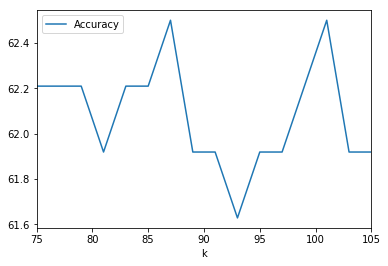

In [16]:
accuracies1.plot(x='k', y='Accuracy')
plt.show()

Best k:

In [17]:
accuracies1[accuracies1['Accuracy'] == accuracies1.max()['Accuracy']]

,k,Accuracy
0,87,62.5
0,101,62.5


### With uniform weights:

#### Custom

In [18]:
accuracies20 = pd.DataFrame(columns = ['k', 'Accuracy'])

for k in range(75, 107, 2):
    knn = kNN(k, weights=uniform)
    knn.fit(train1X, trainY)
    accuracies20 = accuracies20.append(pd.DataFrame([[k, accuracy_score(testY, knn.predict(test1X)) * 100]], 
                                                  columns = ['k', 'Accuracy']))    

In [19]:
accuracies20

,k,Accuracy
0,75,66.860465
0,77,66.569767
0,79,66.860465
0,81,66.569767
0,83,66.279070
0,85,66.569767
0,87,66.569767
0,89,66.569767
0,91,66.569767
0,93,65.406977


---------

#### sklearn

In [20]:
accuracies2 = pd.DataFrame(columns = ['k', 'Accuracy'])

for k in range(75, 107, 2):
    knn = KNeighborsClassifier(k)
    knn.fit(train1X, trainY)
    accuracies2 = accuracies2.append(pd.DataFrame([[k, accuracy_score(testY, knn.predict(test1X)) * 100]], 
                                                  columns = ['k', 'Accuracy']))

In [21]:
accuracies2

,k,Accuracy
0,75,66.860465
0,77,66.569767
0,79,66.860465
0,81,66.569767
0,83,66.279070
0,85,66.569767
0,87,66.569767
0,89,66.569767
0,91,66.569767
0,93,65.406977


#### Accuracies

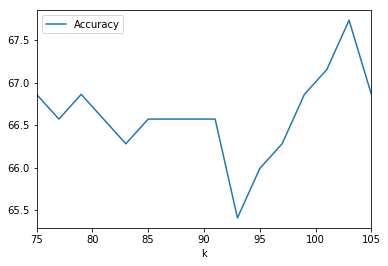

In [22]:
accuracies2.plot(x='k', y='Accuracy')
plt.show()

Best k:

In [23]:
accuracies2[accuracies2['Accuracy'] == accuracies2.max()['Accuracy']]

,k,Accuracy
0,103,67.732558


-------------
---------------
--------------

## Problem 2

In [24]:
lN = linearNormalizator()
train2X = lN.fitAndScale(train2X.drop(['regionN'], axis=1)).join(train2X.loc[:, 'regionN'])
test2X = lN.scale(test2X.drop(['regionN'], axis=1)).join(test2X.loc[:, 'regionN'])

### Conditional probabilities

In [25]:
vdm = VDM()
vdm.fit(train2X['regionN'], trainY)
vdm.condProbs

,0,1
1,0.495495,0.504505
2,0.568579,0.431421
3,0.645995,0.354005
4,0.576087,0.423913


### VDM Distances

In [26]:
vdm.distances

,1,2,3,4
1,0.000000,0.010682,0.045300,0.012990
2,0.010682,0.000000,0.011987,0.000113
3,0.045300,0.011987,0.000000,0.009774
4,0.012990,0.000113,0.009774,0.000000


### kNN

#### Weighted

In [27]:
accuracies3 = pd.DataFrame(columns = ['k', 'Accuracy'])

for k in range(75, 107, 2):
    knn = kNN(k)
    knn.fit(train2X, trainY)
    accuracies3 = accuracies3.append(pd.DataFrame([[k, accuracy_score(testY, knn.predict(test2X)) * 100]], 
                                                  columns = ['k', 'Accuracy']))    

#### Accuracies

In [28]:
accuracies3

,k,Accuracy
0,75,63.953488
0,77,63.372093
0,79,63.081395
0,81,62.790698
0,83,62.500000
0,85,62.500000
0,87,62.209302
0,89,62.209302
0,91,63.081395
0,93,62.790698


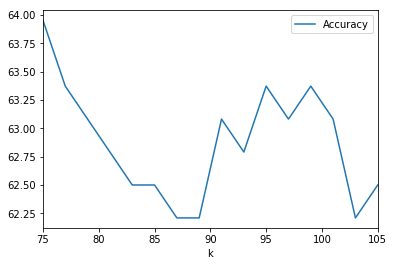

In [29]:
accuracies3.plot(x='k', y='Accuracy')
plt.show()

Best k:

In [30]:
accuracies3[accuracies3['Accuracy'] == accuracies3.max()['Accuracy']]

,k,Accuracy
0,75,63.953488


---------

#### Uniform

In [31]:
accuracies4 = pd.DataFrame(columns = ['k', 'Accuracy'])

for k in range(75, 107, 2):
    knn = kNN(k, weights=uniform)
    knn.fit(train2X, trainY)
    accuracies4 = accuracies4.append(pd.DataFrame([[k, accuracy_score(testY, knn.predict(test2X)) * 100]], 
                                                  columns = ['k', 'Accuracy']))    

#### Accuracies

In [32]:
accuracies4

,k,Accuracy
0,75,65.988372
0,77,64.825581
0,79,64.825581
0,81,65.116279
0,83,64.825581
0,85,65.116279
0,87,63.372093
0,89,64.534884
0,91,64.534884
0,93,64.825581


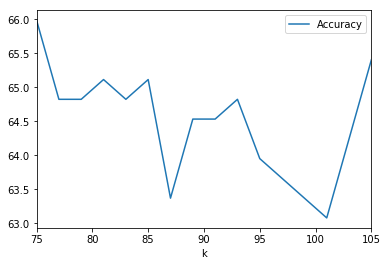

In [33]:
accuracies4.plot(x='k', y='Accuracy')
plt.show()

Best k:

In [34]:
accuracies4[accuracies4['Accuracy'] == accuracies4.max()['Accuracy']]

,k,Accuracy
0,75,65.988372


**Merged charts:**

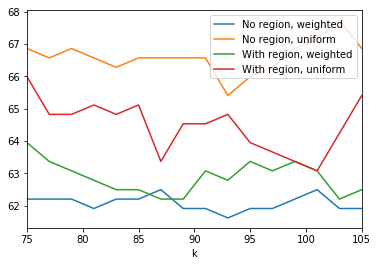

In [35]:
fig, ax = plt.subplots(1, 1)
accuracies1.plot(x='k', y='Accuracy', ax=ax, label='No region, weighted')
accuracies2.plot(x='k', y='Accuracy', ax=ax, label='No region, uniform')
accuracies3.plot(x='k', y='Accuracy', ax=ax, label='With region, weighted')
accuracies4.plot(x='k', y='Accuracy', ax=ax, label='With region, uniform')
plt.show()

## Comparison

In [36]:
print(f"Mean accuracy of weighted model without regionN is {accuracies1.loc[:,'Accuracy'].mean()}.")
print(f"Mean accuracy of weighted model with regionN is {accuracies3.loc[:,'Accuracy'].mean()}.")
print(f"Mean accuracy of uniformly weighted model without regionN is {accuracies2.loc[:,'Accuracy'].mean()}.")
print(f"Mean accuracy of uniformly weighted model with regionN is {accuracies4.loc[:,'Accuracy'].mean()}.")

Mean accuracy of weighted model without regionN is 62.08212209302326.
Mean accuracy of weighted model with regionN is 62.881540697674424.
Mean accuracy of uniformly weighted model without regionN is 66.6061046511628.
Mean accuracy of uniformly weighted model with regionN is 64.48037790697674.


Accuracy for uniformly weighted model has decreased when we included `regionN`.

**Predictions of points 100, 200, 300**

Weighted:

In [37]:
preds1 = pd.DataFrame(columns = ['k', 'Point 100', 'Point 200', 'Point 300'])

for k in range(75, 107, 2):
    knn = kNN(k)
    knn.fit(train2X, trainY)
    preds1 = preds1.append(pd.DataFrame([[k, 
                                          knn.predict(test2X.iloc[99,:])[0], 
                                          knn.predict(test2X.iloc[199,:])[0], 
                                          knn.predict(test2X.iloc[299,:])[0]]], 
                                        columns = ['k', 'Point 100', 'Point 200', 'Point 300']))    

In [38]:
preds1

,k,Point 100,Point 200,Point 300
0,75,0,0,0
0,77,0,0,0
0,79,0,0,0
0,81,0,0,0
0,83,0,0,0
0,85,0,0,0
0,87,0,0,0
0,89,0,0,0
0,91,0,0,0
0,93,0,0,0


Uniform:

In [39]:
preds2 = pd.DataFrame(columns = ['k', 'Point 100', 'Point 200', 'Point 300'])

for k in range(75, 107, 2):
    knn = kNN(k, weights=uniform)
    knn.fit(train2X, trainY)
    preds2 = preds2.append(pd.DataFrame([[k, 
                                          knn.predict(test2X.iloc[99,:])[0], 
                                          knn.predict(test2X.iloc[199,:])[0], 
                                          knn.predict(test2X.iloc[299,:])[0]]], 
                                        columns = ['k', 'Point 100', 'Point 200', 'Point 300']))    

In [40]:
preds2

,k,Point 100,Point 200,Point 300
0,75,0,0,0
0,77,0,0,0
0,79,0,0,0
0,81,0,0,0
0,83,0,0,0
0,85,0,0,0
0,87,0,0,0
0,89,0,0,0
0,91,0,0,0
0,93,0,0,0
